# Analysis of flight data using the DataFrame API and SparkSQL


## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.


In [257]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import when, lit


sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [258]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [259]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
#df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [260]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round, mean
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [261]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [262]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [263]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|208224|
|     US|170397|
|     AA|142832|
|     WN|124024|
|     UA|113640|
|     NW|100453|
|     CO| 94501|
|     TW| 54771|
|     HP| 44351|
|     AS| 25010|
+-------+------+



# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? 
Then we will discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [264]:
print ("There are", len(df.groupBy(df.src_airport).count().collect()), "origin airports")
print ("There are", len(df.groupBy(df.dest_airport).count().collect()), "destination airports")

There are 224 origin airports
There are 225 destination airports


<h4> Discussion </h4>
    
- A dataset of flights **would normally** process an **equal number of airports between origins and destinations**. 
- Each airport is counted as an origin and destination airport. Thus, the number of airports in both categories should be equal. In this case, there is one airport that is only counted as a destination airport, meaning it has no flights departing from it.
This is strange as airports usually have both departing and incoming flights.

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [265]:
unique_carriers_df = df.groupBy(df.carrier).count()
print ("There are", len(unique_carriers_df.collect()), "carriers. Here is the full list of these carriers:")
unique_carriers_df.select('carrier').show()

There are 10 carriers. Here is the full list of these carriers:
+-------+
|carrier|
+-------+
|     UA|
|     AA|
|     NW|
|     HP|
|     TW|
|     DL|
|     US|
|     AS|
|     CO|
|     WN|
+-------+



### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>

<br>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [266]:
nb_night_flights = df.filter(~df.scheduled_departure_time.between(600,1800)).count()
total_number_of_filghts = df.count()

print ("The number of night filghts is:", nb_night_flights)
print ("The total number of flights is:", total_number_of_filghts)
print ("The percentage of night flights is:", format(100*nb_night_flights/total_number_of_filghts, '.2f'), "%")

The number of night filghts is: 1121918
The total number of flights is: 5180048
The percentage of night flights is: 21.66 %


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


In [267]:
monthly_volume = df.groupBy(df.month).count().orderBy('month', ascending=1)
monthly_volume.show()

+-----+------+
|month| count|
+-----+------+
|    1|423861|
|    2|386954|
|    3|435516|
|    4|420995|
|    5|436432|
|    6|426490|
|    7|443736|
|    8|451086|
|    9|430861|
|   10|449369|
|   11|428227|
|   12|446521|
+-----+------+



In [268]:
def plot_monthly_volume(volume, title):
    volume = np.array(volume.collect()) #transform list of spark rows to matrix of values of shape (12,2) = (month, volume) 
    plt.figure(figsize=(10,5))
    plt.plot(volume[:, 0], volume[:, 1])
    plt.ylabel('number of flights', size="x-large")
    plt.xlabel('month', size="x-large")
    plt.xticks(volume[:,0], range(1, 13))
    plt.title(title, size = 'xx-large')
    plt.grid(True,which="both",ls="-")
    plt.show()


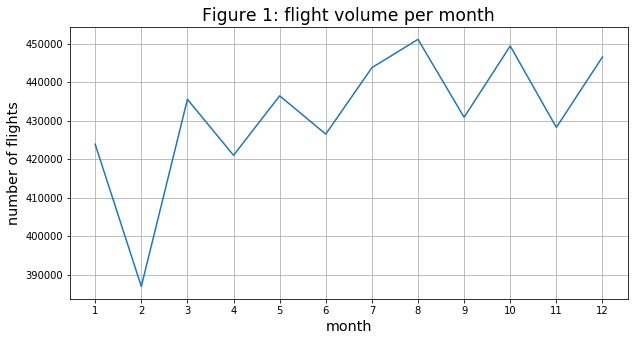

In [269]:
plot_monthly_volume(monthly_volume, title="Figure 1: flight volume per month")

<h2>Comment on the figure </h2>

- The figure above (Figure 1) shows a **higher number of flights during summer (July and August)**,
  as it is a **holiday season**, and during **october and December**.
    - These months are most likely to experience flight delays as they have a larger number of flights 
- The start of the year (**January to Mai**), along with the months of **September and November** are **less likely** to experience **flights delays** due to a **lower traffic**

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Lets us plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> We should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

In [270]:
day_of_week_volume_per_year = df.groupBy(df.day_of_week).count().orderBy('day_of_week', ascending=1)
day_of_week_volume_per_year.show()

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|754636|
|          2|756532|
|          3|756864|
|          4|751537|
|          5|751531|
|          6|695245|
|          7|713703|
+-----------+------+



In [271]:
#Function to plot the volume of flights per day on a given duration (first column of the list)

def plot_volume (list_volume, title, xlabel, ylabel):
    array_volume = np.array(list_volume.collect())
    volume = array_volume[:, 1]
    volume_max, volume_min = volume.max(), volume.min()
    volume_range = volume_max - volume_min
    plt.figure(figsize=(15,5))
    bars = plt.bar(array_volume[:,0], volume, align='center', edgecolor = "black")
    plt.ylabel(ylabel, size="x-large")
    plt.ylim(volume_min*0.99, volume_max*1.01)
    plt.xlabel(xlabel, size="x-large")
    plt.xticks(array_volume[:,0], array_volume[:,0])
    plt.title(title, size="xx-large")
    plt.grid(True,which="both",ls="-")
    #plt.show()
    
    for i in range(0, len(bars)):
        color = 'red'
        if volume[i] - volume_min < 0.2*volume_range:
            color = 'lightgreen'
        elif volume[i] - volume_min < 0.4*volume_range:
            color = 'green'
        elif volume[i] - volume_min < 0.6*volume_range:
            color = 'yellow'
        elif volume[i] - volume_min < 0.8*volume_range: 
            color = 'orange'

        bars[i].set_color(color)
        
    patch1 = mpatches.Patch(color='lightgreen', label='low')
    patch2 = mpatches.Patch(color='green', label='moderate')
    patch3 = mpatches.Patch(color='yellow', label='high')
    patch4 = mpatches.Patch(color='orange', label='very high')
    patch5 = mpatches.Patch(color='red', label='peak')

    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.margins(0.05, 0)
    plt.show()

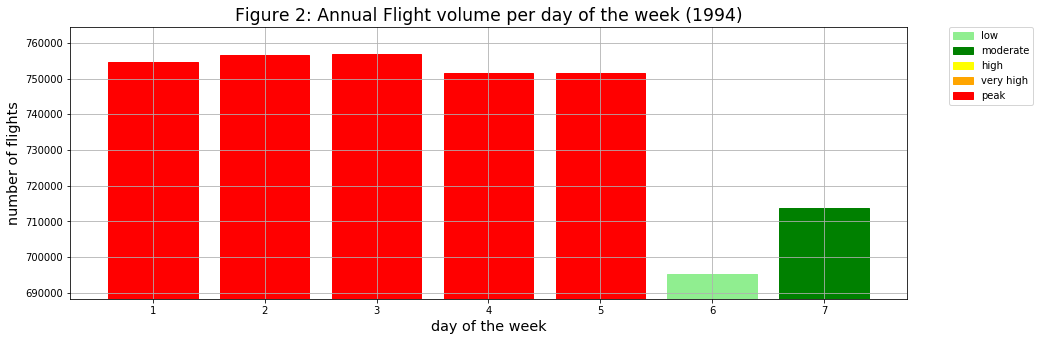

In [272]:
plot_volume(day_of_week_volume_per_year, 'Figure 2: Annual Flight volume per day of the week (1994)', 'day of the week', 'number of flights')

<h2> Comment on the figure </h2>

- The figure above  (Figure 2) shows a clear relationship between the number of flights and the days of the week: 
**Passengers fly considerably more during week days (Monday to Friday), therefore increasing the probability of flight delays during these days of the week.**
- However, this figure gives a general annual representation (high-level) of the dynamic of flights during the days of the week. 
It is very important to inspect the volume per month as the dynamics change depending on the month (i.e. period of the year. ex: holidays, new year, etc.)  

In [273]:
#Function to subplot all the figures of the different months into a single figure 

def plot_volume_per_month (list_volume, max_val, min_val, title, xlabel, ylabel, ax):
    array_volume = np.array(list_volume)
    volume = array_volume[:, 1]
    volume_max, volume_min = max_val, min_val
    volume_diff = (volume_max-volume_min)
    
    bars = ax.bar(array_volume[:,0], volume, align='center', edgecolor = "black")
    ax.set_ylabel(ylabel, size="x-large")
    ax.set_ylim(volume_min*0.95, volume_max*1.05)
    ax.set_xlabel(xlabel, size="x-large")
    ax.set_title(title, size="xx-large")
    ax.grid(True,which="both",ls="-")
    
    for i in range(0, len(bars)):
        color = 'red'
        if volume[i] - volume_min < 0.33*volume_diff:
            color = 'lightgreen'
        elif volume[i] - volume_min < 0.66*volume_diff:
            color = 'orange'

        bars[i].set_color(color)
        
    patch1 = mpatches.Patch(color='lightgreen', label='low')
    patch2 = mpatches.Patch(color='orange', label='medium')
    patch3 = mpatches.Patch(color='red', label='high')
    ax.legend(handles=[patch1, patch2, patch3], bbox_to_anchor=(1.05, 1), borderaxespad=0., loc=2)
    ax.margins(0.05, 0)

In [274]:
flight_volume_per_day_of_week_per_month = df.groupBy(['year', 'month', 'day_of_week'])\
    .agg((func.count('*')).alias('flight_volume'))

## assume that we do statistic on year 1994
flight_volume_per_day_of_week_per_month = flight_volume_per_day_of_week_per_month\
    .orderBy('year', 'month', 'day_of_week')

#create a pandas dataframe with the volume per day of the week per month
pdf_flight_volume_per_day_of_week_per_month = pd.DataFrame(data=flight_volume_per_day_of_week_per_month.collect())

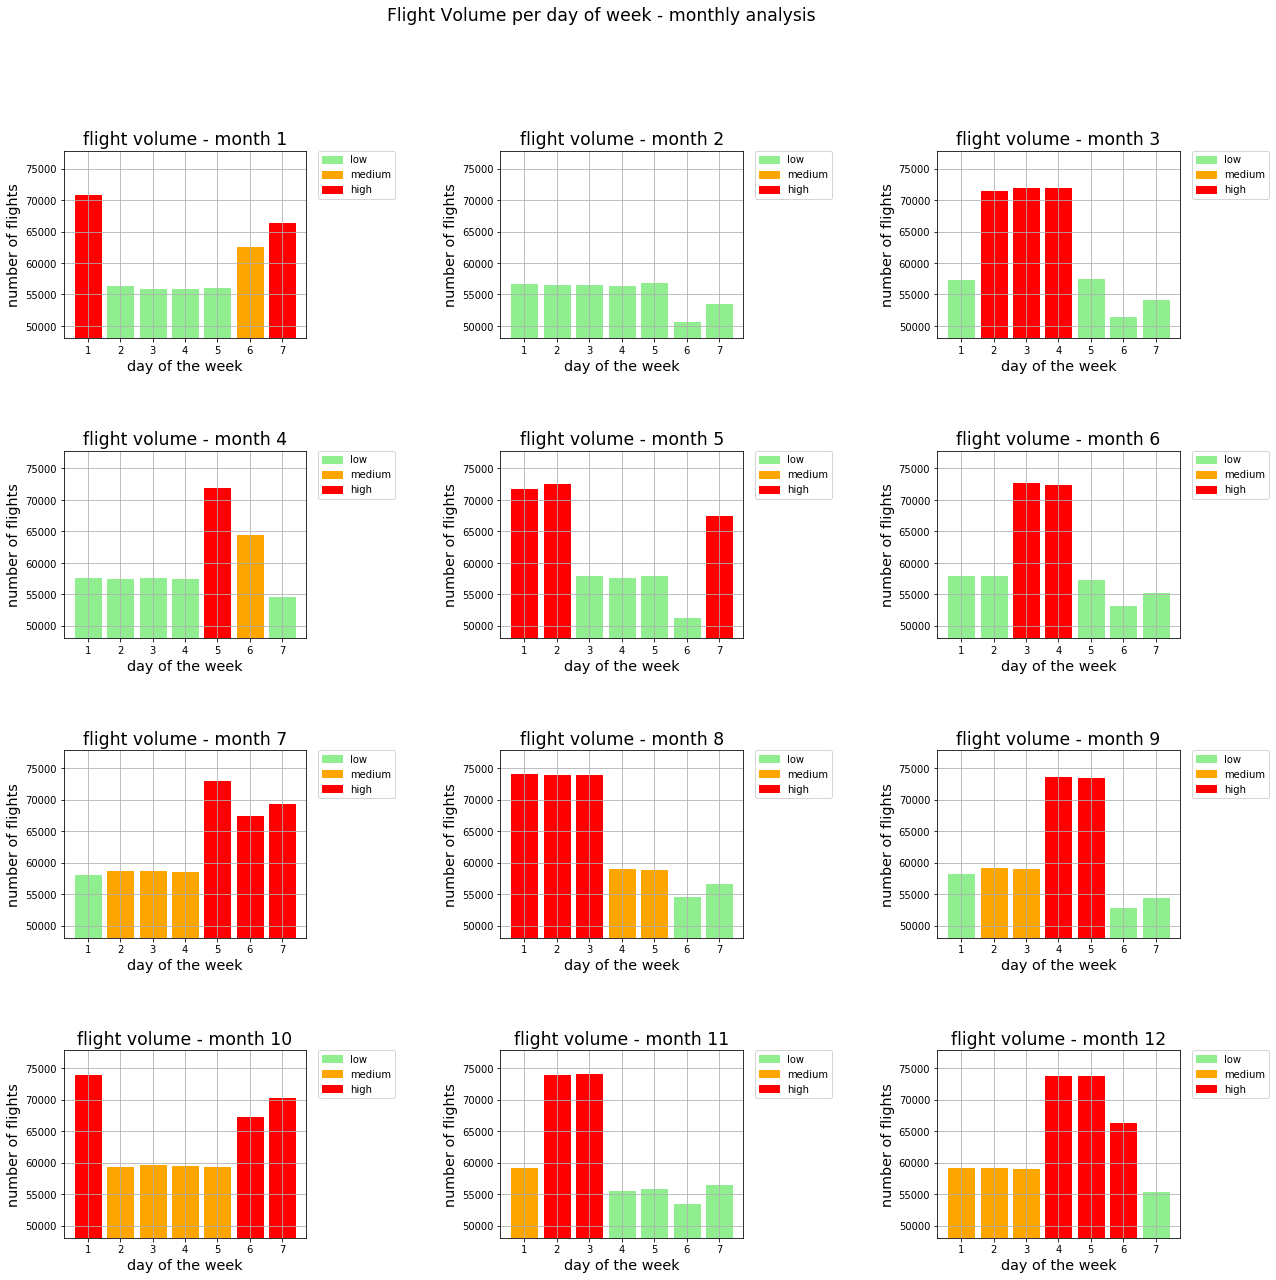

In [275]:
fig, axs = plt.subplots(4, 3, figsize=(20,20))
fig.subplots_adjust(wspace=0.8, hspace=0.6)
fig.suptitle("Flight Volume per day of week - monthly analysis ", size='xx-large')
max_val, min_val = max(pdf_flight_volume_per_day_of_week_per_month[3]), min(pdf_flight_volume_per_day_of_week_per_month[3])

for row in range(4):
    for col in range(3):
        ax = axs[row,col]
        title = 'flight volume - month {}'.format(3*row+col+1)
        volume = pdf_flight_volume_per_day_of_week_per_month[(pdf_flight_volume_per_day_of_week_per_month[1] == (3*row+col+1))][[2,3]]
        plot_volume_per_month (volume, max_val, min_val, title, 'day of the week', 'number of flights', ax)

<h2> Comments </h2>
    
- The plots above show a clear **pattern in flight volume per day of the week** depending on the month. The general pattern can be **categorized into weekend / weekdays**
- An example of this is **March** (3) where we can see a large difference between **weekend (low)** and **weekdays (high)** flight volume.
- **January (1)** is the opposite with a **large flight volume during weekends** and a low one during weekdays.

- In general, the months of **March, Mai, September, November and December** are expected to have a **higher flight volume during weekdays** (therefore more delays during these days)
- **January, Mai, July and October** have a **high weekends flight volume**

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, We need to compute both global statistcs and monthly statistics.

<br>
<br>
Let us plot  bar charts, and interpret our figures.
</div>

In [276]:
day_of_month_volume = df.groupBy(df.day_of_month).count().orderBy('day_of_month', ascending=1)
day_of_month_volume.show(31)

+------------+------+
|day_of_month| count|
+------------+------+
|           1|169674|
|           2|169829|
|           3|168678|
|           4|169399|
|           5|168423|
|           6|170650|
|           7|172210|
|           8|170674|
|           9|170077|
|          10|170252|
|          11|172362|
|          12|169542|
|          13|171230|
|          14|172081|
|          15|170737|
|          16|169985|
|          17|170132|
|          18|171868|
|          19|169483|
|          20|171142|
|          21|172283|
|          22|171305|
|          23|170695|
|          24|166379|
|          25|167435|
|          26|168767|
|          27|171222|
|          28|171760|
|          29|155695|
|          30|155915|
|          31|100164|
+------------+------+



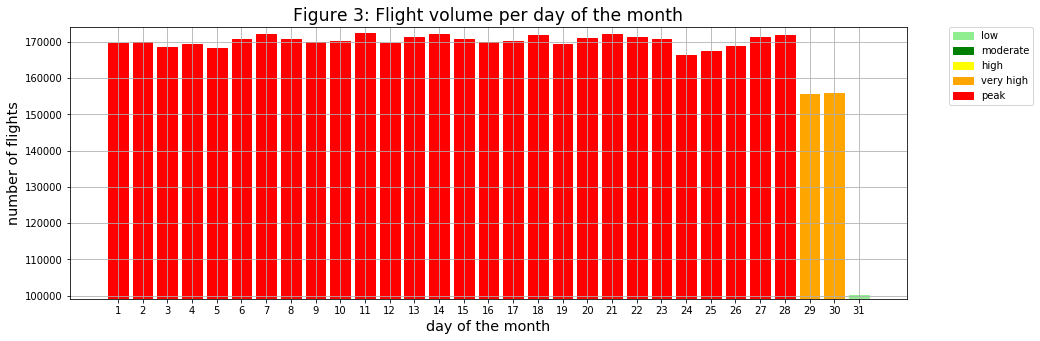

In [277]:
plot_volume(day_of_month_volume, 'Figure 3: Flight volume per day of the month', 'day of the month', 'number of flights')

In [278]:
flight_volume_per_day_of_month_per_month = df.groupBy(['year', 'month', 'day_of_month'])\
    .agg((func.count('*')).alias('flight_volume'))

## assume that we do statistic on year 1994
flight_volume_per_day_of_month_per_month = flight_volume_per_day_of_month_per_month\
    .orderBy('year', 'month', 'day_of_month')

#create a pandas dataframe with the volume per day of the week per month
pdf_flight_volume_per_day_of_month_per_month = pd.DataFrame(data=flight_volume_per_day_of_month_per_month.collect())

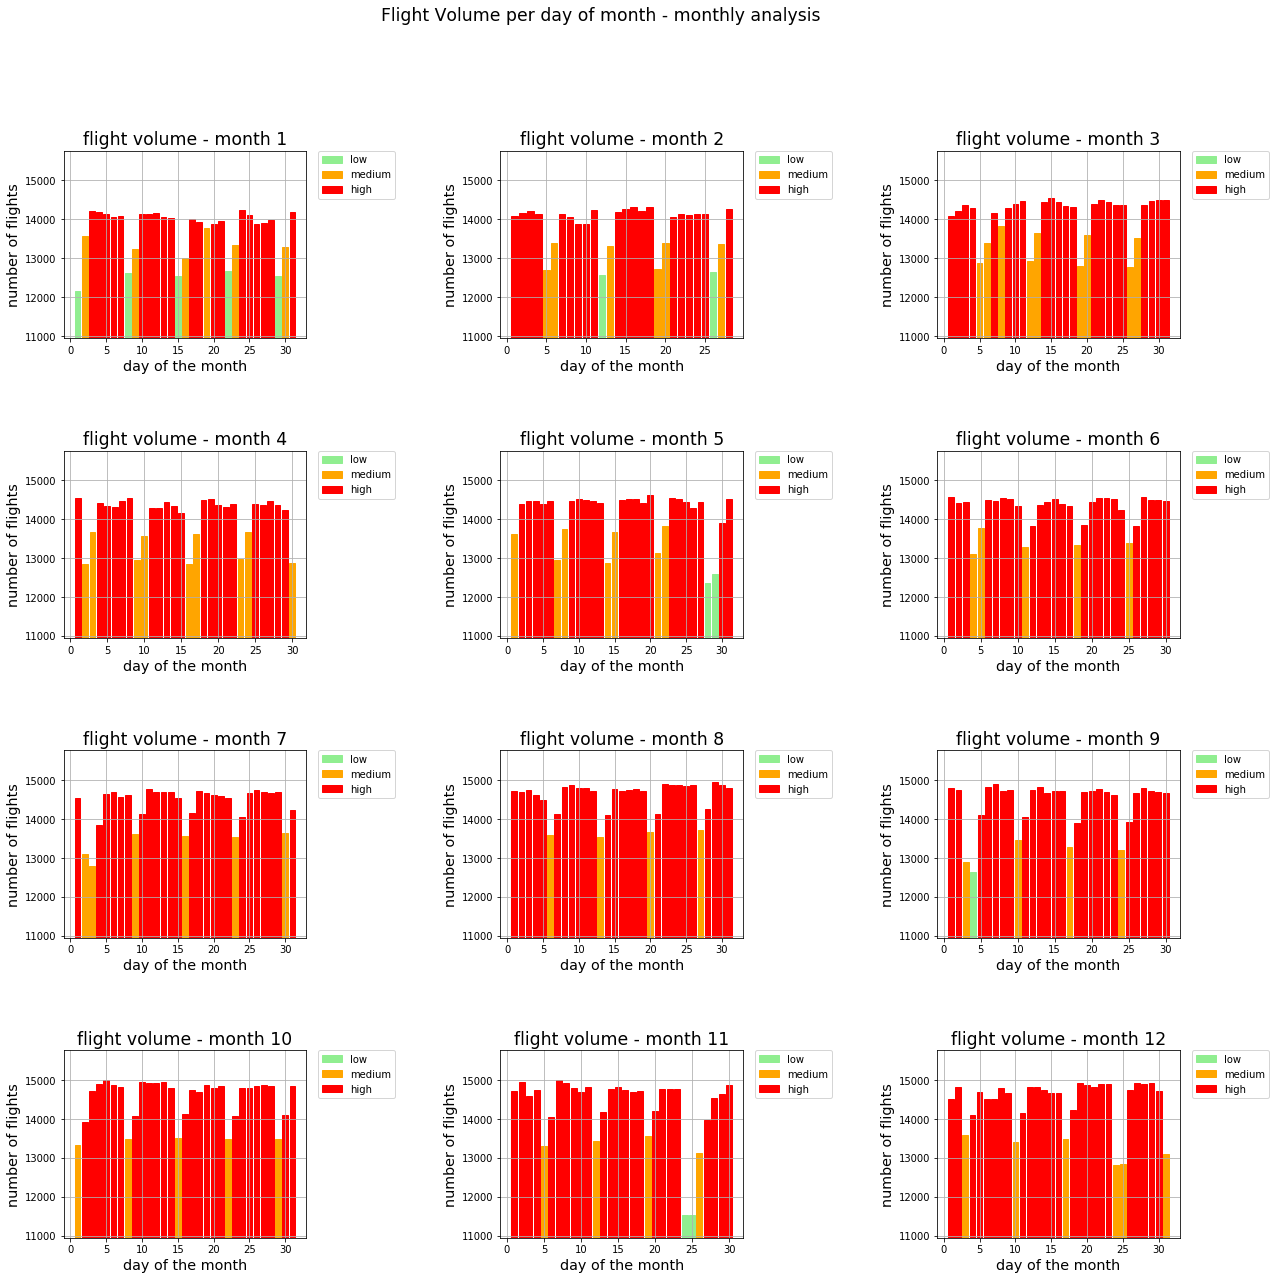

In [279]:
fig, axs = plt.subplots(4, 3, figsize=(20,20))
fig.subplots_adjust(wspace=0.8, hspace=0.6)
fig.suptitle("Flight Volume per day of month - monthly analysis ", size='xx-large')
max_val, min_val = max(pdf_flight_volume_per_day_of_month_per_month[3]), min(pdf_flight_volume_per_day_of_month_per_month[3])

for row in range(4):
    for col in range(3):
        
        ax = axs[row,col]
        title = 'flight volume - month {}'.format(3*row+col+1)
        volume = pdf_flight_volume_per_day_of_month_per_month[(pdf_flight_volume_per_day_of_month_per_month[1] == (3*row+col+1))][[2,3]]
        plot_volume_per_month(volume, max_val, min_val, title, 'day of the month', 'number of flights', ax)




<h2> Comments </h2>
    
- As shown previously, the plots show a **clear pattern of a categorical dynamic (weekend/weekdays) each month**, as we can see through an **important variation in the volume every 5 days**. This confirms the previous analysis of flight volume per day of the week.
- As for the day of the month, there is no other dynamic specific to a date of the month (variation is a result of the day of the week's dynamic), a part from a decrease in flights volume at the end of the month (29th, 30th, 31st), which is explained by the month of February (up to 28)

In [280]:
df_per_hour_of_day = df.withColumn('hour_of_day', (df['scheduled_departure_time']/100).cast('int'))

flight_volume_per_hour_of_day = df_per_hour_of_day.groupBy(['hour_of_day'])\
    .agg((func.count('*')).alias('flight_volume'))

## assume that we do statistic on year 1994
flight_volume_per_hour_of_day = flight_volume_per_hour_of_day\
    .orderBy('hour_of_day')

#create a pandas dataframe with the volume per day of the week per month
pdf_flight_volume_per_hour_of_day = pd.DataFrame(data=flight_volume_per_hour_of_day.collect())

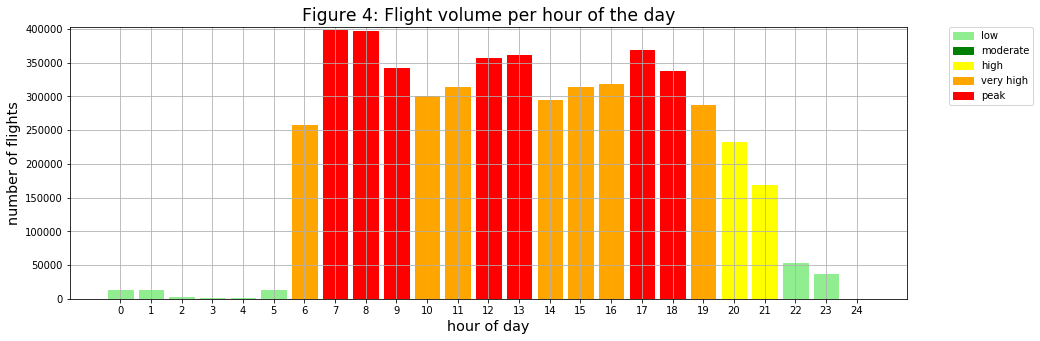

In [281]:
plot_volume(flight_volume_per_hour_of_day, 'Figure 4: Flight volume per hour of the day', 'hour of day', 'number of flights')

In [282]:
flight_volume_per_hour_of_day_per_month = df_per_hour_of_day.groupBy(['year','month', 'hour_of_day'])\
    .agg((func.count('*')).alias('flight_volume'))

## assume that we do statistic on year 1994
flight_volume_per_hour_of_day_per_month = flight_volume_per_hour_of_day_per_month\
    .orderBy('year', 'month','hour_of_day')

#create a pandas dataframe with the volume per day of the week per month
pdf_flight_volume_per_hour_of_day_per_month = pd.DataFrame(data=flight_volume_per_hour_of_day_per_month.collect())

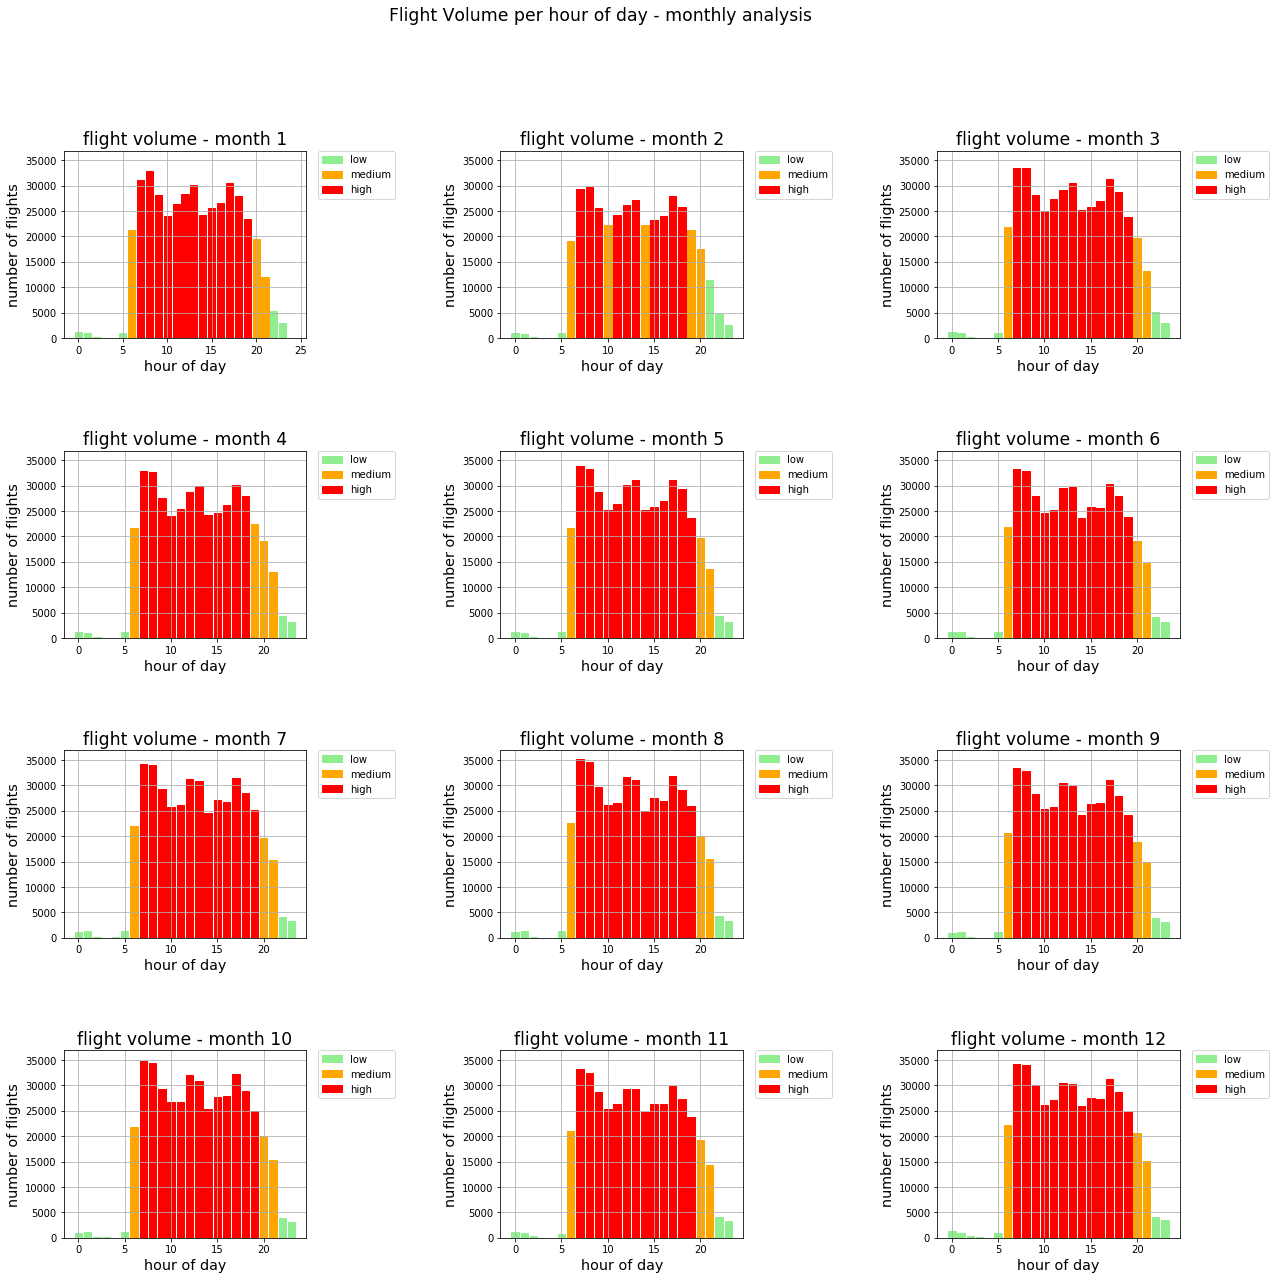

In [283]:
fig, axs = plt.subplots(4, 3, figsize=(20,20))
fig.subplots_adjust(wspace=0.8, hspace=0.6)
fig.suptitle("Flight Volume per hour of day - monthly analysis ", size='xx-large')
max_val, min_val = max(pdf_flight_volume_per_hour_of_day_per_month[3]), min(pdf_flight_volume_per_hour_of_day_per_month[3])


for row in range(4):
    for col in range(3):
        ax = axs[row,col]
        title = 'flight volume - month {}'.format(3*row+col+1)
        volume = pdf_flight_volume_per_hour_of_day_per_month[(pdf_flight_volume_per_hour_of_day_per_month[1] == (3*row+col+1))][[2,3]]
        plot_volume_per_month(volume, max_val, min_val, title, 'hour of day','number of flights', ax)

<h2> Comments </h2>
    
- As shown in the first section, the **majority of flights depart between 6am and 6pm** (around 80% of the total flights)
- We see a **very similar distribution of flights every day of the month** between the months of the year. This is logical as airports usually schedule the same flights every day and at the same time.

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports?
Let us compute this in terms of the inbound, outbound and total number of flights.
</div>

In [284]:
#inbound
df_inbound = df.groupBy(df.dest_airport).count().orderBy('count', ascending=0).withColumnRenamed('count', 'total_inbound')
df_inbound.show(20)

+------------+-------------+
|dest_airport|total_inbound|
+------------+-------------+
|         ORD|       283720|
|         DFW|       260249|
|         ATL|       221588|
|         LAX|       152959|
|         STL|       152800|
|         DEN|       144099|
|         PHX|       140979|
|         DTW|       139435|
|         PIT|       131962|
|         CLT|       130321|
|         MSP|       124758|
|         SFO|       117245|
|         EWR|       117223|
|         IAH|       104409|
|         LGA|       101498|
|         BOS|        99331|
|         LAS|        94948|
|         PHL|        93312|
|         DCA|        87670|
|         MCO|        76600|
+------------+-------------+
only showing top 20 rows



In [285]:
#outbound
df_outbound = df.groupBy(df.src_airport).count().orderBy('count', ascending=0).withColumnRenamed('count', 'total_outbound')
df_outbound.show(20)

+-----------+--------------+
|src_airport|total_outbound|
+-----------+--------------+
|        ORD|        277741|
|        DFW|        256274|
|        ATL|        221486|
|        LAX|        153494|
|        STL|        151609|
|        DEN|        141427|
|        PHX|        139581|
|        DTW|        136837|
|        PIT|        130977|
|        CLT|        129391|
|        MSP|        123222|
|        SFO|        118233|
|        EWR|        116768|
|        IAH|        104182|
|        LGA|        101864|
|        BOS|        100365|
|        LAS|         94972|
|        PHL|         93585|
|        DCA|         88445|
|        MCO|         77120|
+-----------+--------------+
only showing top 20 rows



In [286]:
df_busiest_airports = df_inbound.join(df_outbound, df_inbound['dest_airport'] == df_outbound['src_airport'])
df_busiest_airports = df_busiest_airports.withColumn('total', df_busiest_airports.total_inbound + df_busiest_airports.total_outbound)
df_busiest_airports = df_busiest_airports.orderBy(df_busiest_airports.total, ascending=0)
df_busiest_airports = df_busiest_airports.select(df_busiest_airports.dest_airport.alias("airport"), df_busiest_airports.total.alias('total_flight'))
df_busiest_airports.show(20)

+-------+------------+
|airport|total_flight|
+-------+------------+
|    ORD|      561461|
|    DFW|      516523|
|    ATL|      443074|
|    LAX|      306453|
|    STL|      304409|
|    DEN|      285526|
|    PHX|      280560|
|    DTW|      276272|
|    PIT|      262939|
|    CLT|      259712|
|    MSP|      247980|
|    SFO|      235478|
|    EWR|      233991|
|    IAH|      208591|
|    LGA|      203362|
|    BOS|      199696|
|    LAS|      189920|
|    PHL|      186897|
|    DCA|      176115|
|    MCO|      153720|
+-------+------------+
only showing top 20 rows



### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Let us compute this in terms of number of flights.
</div>


In [287]:
df_busiest_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
df_busiest_carriers =df_busiest_carriers.withColumnRenamed('count', 'total_flights')

df_busiest_carriers.show(20)

+-------+-------------+
|carrier|total_flights|
+-------+-------------+
|     DL|       874526|
|     US|       857906|
|     AA|       722277|
|     UA|       638750|
|     WN|       565426|
|     CO|       484834|
|     NW|       482798|
|     TW|       258205|
|     HP|       177851|
|     AS|       117475|
+-------+-------------+



## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Let us plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

In [288]:
#create a dataframe with a new column "delay" to categorize delayed and non-delayed flights
df_with_delay = df_per_hour_of_day.withColumn('is_delay', when(df_per_hour_of_day["arrival_delay"] >= 15, 1).otherwise(0))
delay_ratio_per_hour = df_with_delay.groupBy(['hour_of_day'])\
    .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_percentage'))

# assume that we do statistic on year 1994
delay_ratio_per_hour = delay_ratio_per_hour\
    .orderBy('hour_of_day')
pdf_delay_ratio_per_hour = pd.DataFrame(data=delay_ratio_per_hour.collect())

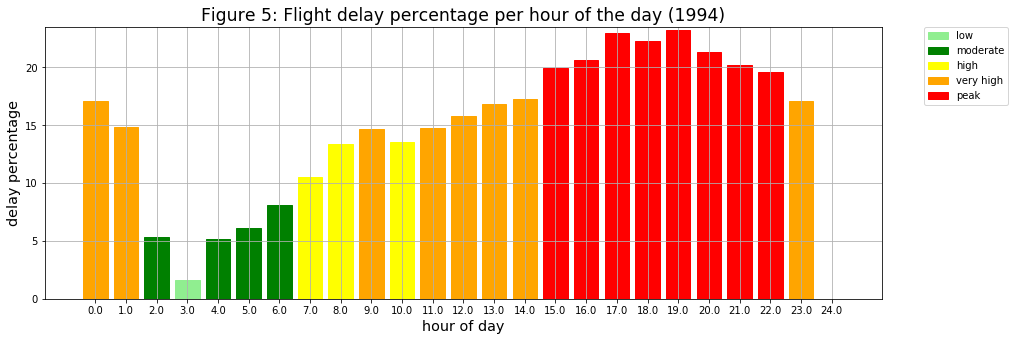

In [289]:
plot_volume(delay_ratio_per_hour, 'Figure 5: Flight delay percentage per hour of the day (1994)', 'hour of day', 'delay percentage')

In [290]:
delay_ratio_per_hour_per_month = df_with_delay.groupBy(['year', 'month','hour_of_day'])\
    .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_percentage'))

# assume that we do statistic on year 1994
delay_ratio_per_hour_per_month = delay_ratio_per_hour_per_month\
    .orderBy('year', 'month', 'hour_of_day')
pdf_delay_ratio_per_hour_per_month = pd.DataFrame(data=delay_ratio_per_hour_per_month.collect())

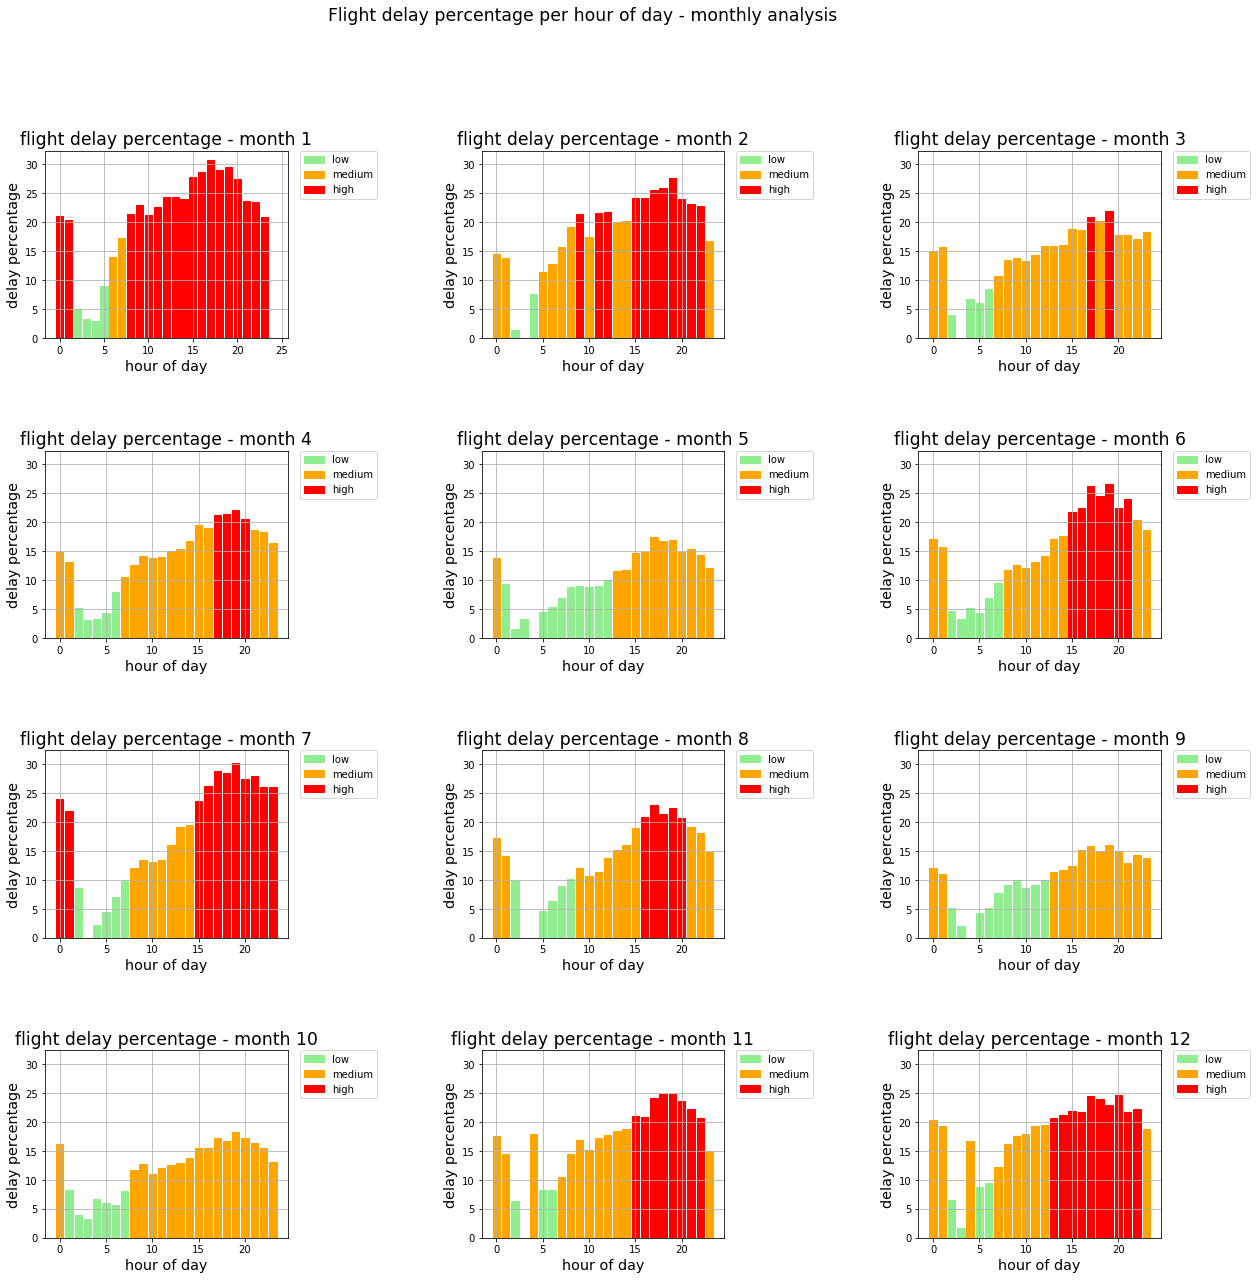

In [291]:
fig, axs = plt.subplots(4, 3, figsize=(20,20))
fig.subplots_adjust(wspace=0.8, hspace=0.6)
fig.suptitle("Flight delay percentage per hour of day - monthly analysis ", size='xx-large')
max_val, min_val = max(pdf_delay_ratio_per_hour_per_month[3]), min(pdf_delay_ratio_per_hour_per_month[3])

for row in range(4):
    for col in range(3):
        ax = axs[row,col]
        title = 'flight delay percentage - month {}'.format(3*row+col+1)
        volume = pdf_delay_ratio_per_hour_per_month[(pdf_delay_ratio_per_hour_per_month[1] == (3*row+col+1))][[2,3]]
        plot_volume_per_month(volume, max_val, min_val, title, 'hour of day', 'delay percentage', ax)

<h2> Comments </h2>
    
- The Figure 5 shows that **flights departing early in the morning (from 2 to 6 am) are less likely to be delayed** (**less than 5%** of the flights **delayed** during these hours).
- On the contrary, it shows that flights **departing between 3pm and 10pm** are **more likely to be delayed** with a **percentage of delayed flights higher than 20%**, meaning **1 out of 5 planes departing** during these hours are **delayed**

### Question 4.2
<div class="alert alert-info">
We realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving us a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Let us plot a Bar chart and explain it.  

</div>

In [292]:
mean_delay_per_hour = df_with_delay.groupBy(['hour_of_day'])\
    .agg((func.sum('arrival_delay')/func.count('*')).alias('mean_delay'))

mean_delay_per_hour = mean_delay_per_hour\
    .orderBy('hour_of_day')
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour.collect())

In [293]:
#One flight has been pocessed with a departure time of 2400, and has a delay of 7min
df.filter(df.scheduled_departure_time.between(2400,2500)).agg({"arrival_delay": "avg"}).show()

+------------------+
|avg(arrival_delay)|
+------------------+
|               7.0|
+------------------+



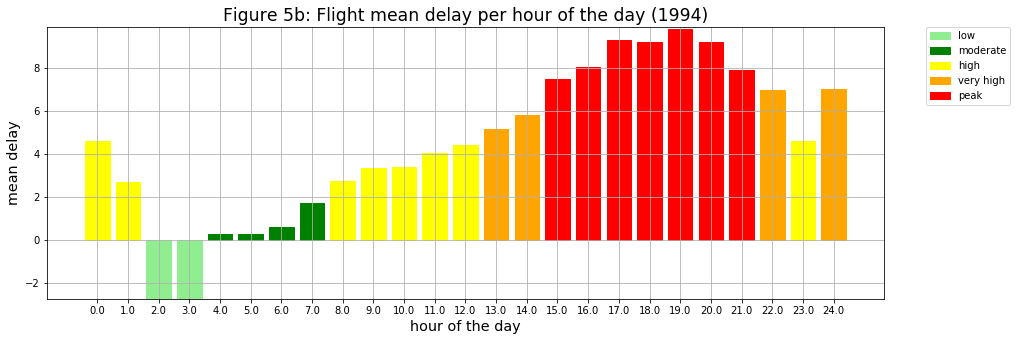

In [294]:
plot_volume(mean_delay_per_hour, "Figure 5b: Flight mean delay per hour of the day (1994)", "hour of the day", 'mean delay')

<h2> Comments </h2>
    
- The Figure 5b complements the previous analysis. It shows that **flights departing early in the morning (from 2 to 6 am) not only are less likely to be delayed, there are more likely to depart early**
- On the contrary, it shows that flights **departing between 4pm and 8pm** have a **mean delay of at least 8 minutes**

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, we should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

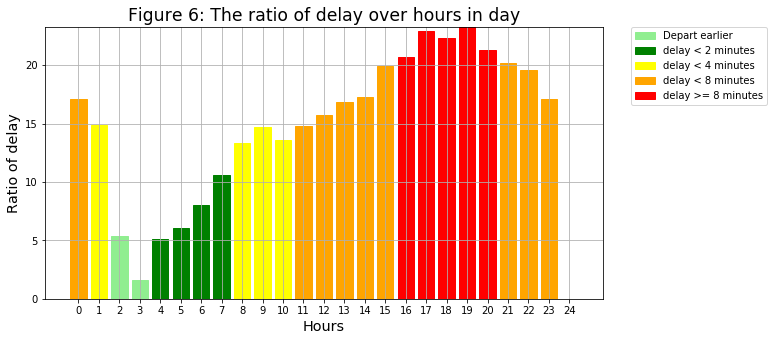

In [295]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.figure(figsize=(10, 5))
plt.xlabel("Hours", size='x-large')
plt.ylabel("Ratio of delay", size='x-large')
plt.title('Figure 6: The ratio of delay over hours in day', size='xx-large')
plt.grid(True,which="both",ls="-")
plt.xticks(range(25), range(25))
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Additional question

<div class="alert alert-info">

delay percentage per month
</div>

In [296]:
delay_ratio_per_month = df_with_delay.groupBy(['month'])\
    .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_percentage'))

# assume that we do statistic on year 1994
delay_ratio_per_month = delay_ratio_per_month\
    .orderBy('month')
pdf_delay_ratio_per_month = pd.DataFrame(data=delay_ratio_per_month.collect())

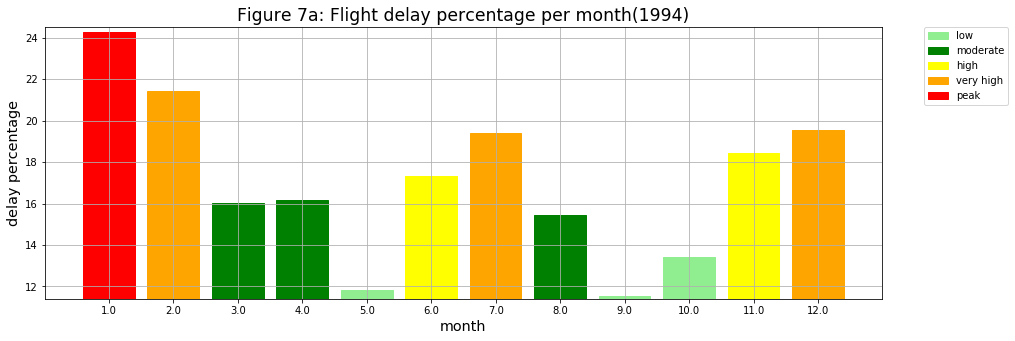

In [297]:
plot_volume(delay_ratio_per_month, 'Figure 7a: Flight delay percentage per month(1994)', 'month', 'delay percentage')

In [298]:
array_volume_per_month = np.array(monthly_volume.collect())

<h2> Comments </h2>
    
- The Figure 7a shows that **flights departing between November and February** are **more likely to experience delays**.
- It also shows that flights departing in **Mai and September** are **less likely to experience delays**

### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

In [299]:
delay_ratio_per_day_of_month = df_with_delay.groupBy(['day_of_month'])\
    .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_percentage'))

# assume that we do statistic on year 1994
delay_ratio_per_day_of_month = delay_ratio_per_day_of_month\
    .orderBy('day_of_month')
pdf_delay_ratio_per_day_of_month = pd.DataFrame(data=delay_ratio_per_day_of_month.collect())

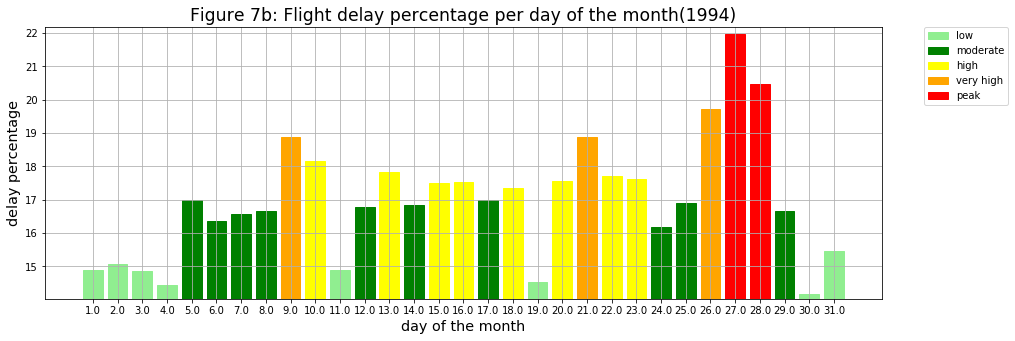

In [300]:
plot_volume(delay_ratio_per_day_of_month, 'Figure 7b: Flight delay percentage per day of the month(1994)', 'day of the month', 'delay percentage')

<h2> Comments </h2>
    
- The Figure 7 shows that **flights departing between the 25th and 28th** of the month are **more likely to experience delays**.
- It also show that flights at the **beginning and very end of the month** are **less likely to be delayed**
- This result should be **further investigated** by looking at this pattern in **each month of the year**

In [301]:
delay_ratio_per_day_of_month_per_month = df_with_delay.groupBy(['year', 'month', 'day_of_month'])\
    .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_percentage'))

# assume that we do statistic on year 1994
delay_ratio_per_day_of_month_per_month = delay_ratio_per_day_of_month_per_month\
    .orderBy('year', 'month', 'day_of_month')
pdf_delay_ratio_per_day_of_month_per_month = pd.DataFrame(data=delay_ratio_per_day_of_month_per_month.collect())

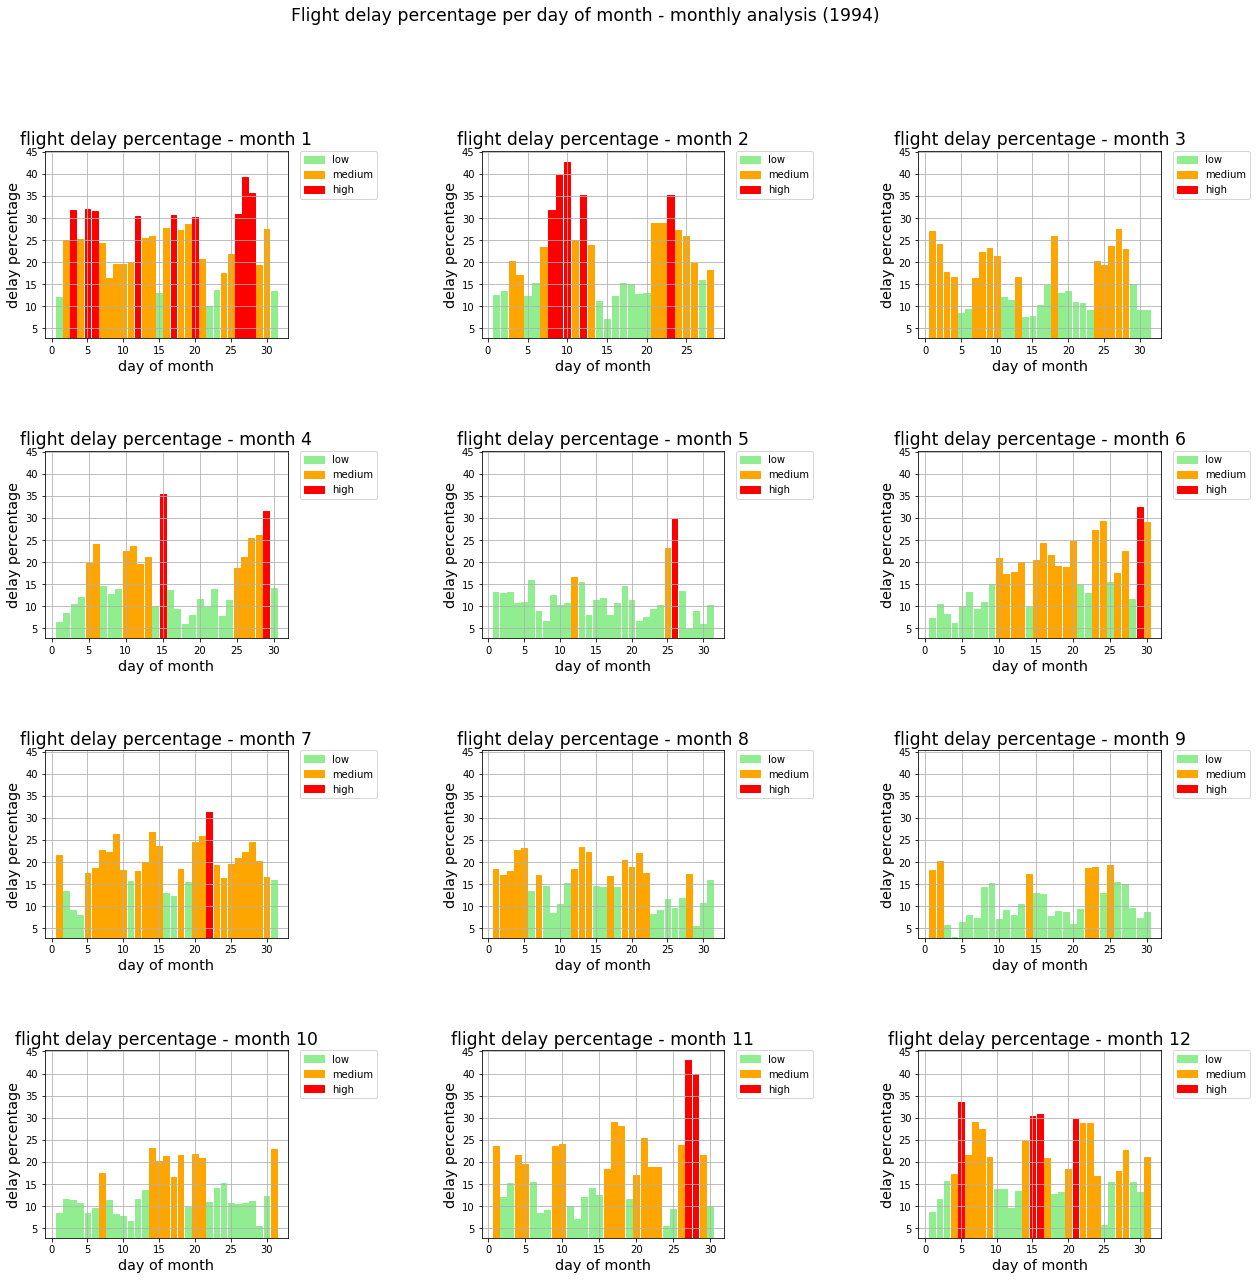

In [302]:
fig, axs = plt.subplots(4, 3, figsize=(20,20))
fig.subplots_adjust(wspace=0.8, hspace=0.6)
fig.suptitle("Flight delay percentage per day of month - monthly analysis (1994)", size='xx-large')
max_val, min_val = max(pdf_delay_ratio_per_day_of_month_per_month[3]), min(pdf_delay_ratio_per_day_of_month_per_month[3])

for row in range(4):
    for col in range(3):
        ax = axs[row,col]
        title = 'flight delay percentage - month {}'.format(3*row+col+1)
        volume = pdf_delay_ratio_per_day_of_month_per_month[(pdf_delay_ratio_per_day_of_month_per_month[1] == (3*row+col+1))][[2,3]]
        plot_volume_per_month(volume, max_val, min_val, title, 'day of month', 'delay percentage', ax)

<h2> Comments </h2>
    
- The figures above shows that **flights departing in the beginning or at the end of the month are less likely to be delayed**.
- **May and September** are the months with the **lowest flight delay percentage**, with the majority of days being **less than 10% of delay**
- It also shows **a disparity in the flight delay percentage per day of the month** between the different months during the middle of the month. 
- We can see that the months of holidays have a high number of days with a delay percentage greater than 20% (1 out of 5 planes departing are late):
    - The months of June, July and August are during the summer vacation which knows a higher number of flights concentrated on weekends (**more flights departing within a shorter period ==> more delays**)
    - The same analysis applies to the end of the year holidays (November, December and January) which also experience a higher percentage of delays


### Question 4.4

<div class="alert alert-info">
Let us plot a bar chart to show the percentage of delayed flights over days in a week, and discuss our findings from the figure.
</div>

In [303]:
delay_ratio_per_day_of_week = df_with_delay.groupBy(['day_of_week'])\
    .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_percentage'))

# assume that we do statistic on year 1994
delay_ratio_per_day_of_week = delay_ratio_per_day_of_week\
    .orderBy('day_of_week')
pdf_delay_ratio_per_day_of_week = pd.DataFrame(data=delay_ratio_per_day_of_week.collect())

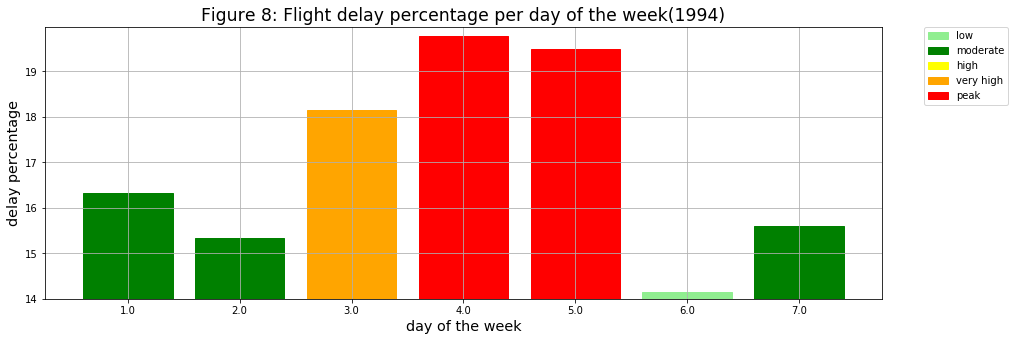

In [304]:
plot_volume(delay_ratio_per_day_of_week, 'Figure 8: Flight delay percentage per day of the week(1994)', 'day of the week', 'delay percentage')

<h2> Comments </h2>
    
- The figure 8 shows that **flights departing on Monday, Tuesday or the weekend** are **less likely to be delayed**

### Question 4.5
<div class="alert alert-info">
Let us plot a bar chart to show the percentage of delayed flights over months in a year, and discuss our findings from the figure.
</div>

In [305]:
delay_ratio_per_month = df_with_delay.groupBy(['month'])\
    .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_percentage'))

# assume that we do statistic on year 1994
delay_ratio_per_month = delay_ratio_per_month\
    .orderBy('month')
pdf_delay_ratio_per_month = pd.DataFrame(data=delay_ratio_per_month.collect())

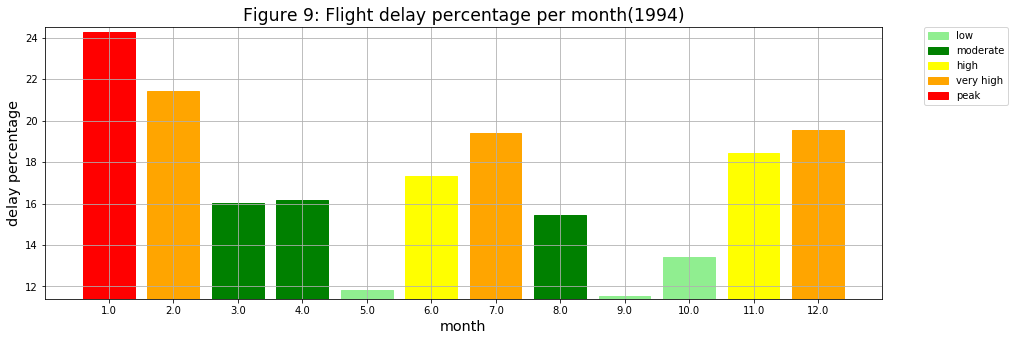

In [306]:
plot_volume(delay_ratio_per_month, 'Figure 9: Flight delay percentage per month(1994)', 'month', 'delay percentage')

<h2> Comments </h2>
    
- The figure 9 shows that **flights departing on Mai and September are very likely to depart on time**, while it's **more likely to depart late from November to February**

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [307]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

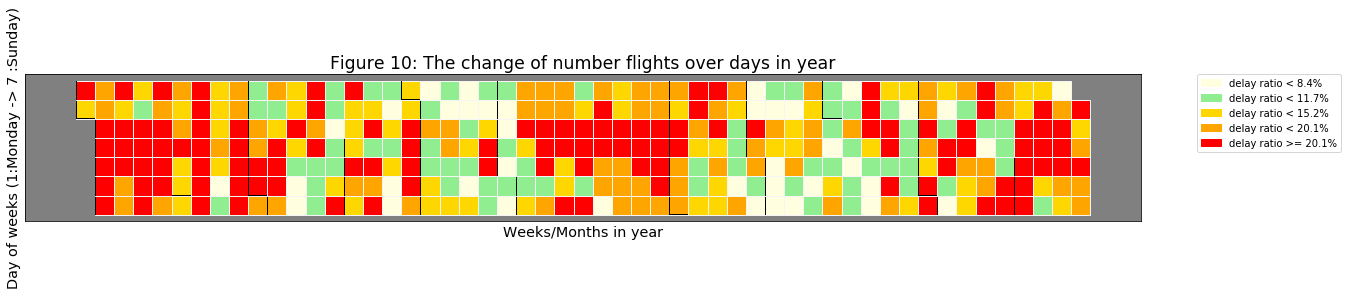

In [308]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year", size='x-large')
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)", size='x-large')
plt.title('Figure 10: The change of number flights over days in year', size='xx-large')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.

In [309]:
pdf_df_busiest_airports = pd.DataFrame(data=df_busiest_airports.collect())
list_busiest_airports = list(pdf_df_busiest_airports[0][0:20])

In [310]:
df_inbound_delay_per_airport = df_with_delay.filter( (df_with_delay.src_airport.isin(list_busiest_airports)) & (df_with_delay.is_delay==1 )).groupBy(df_with_delay.src_airport)\
                            .agg(func.count('*').alias('inbound_delay_count')).orderBy('inbound_delay_count', ascending=0)

df_outbound_delay_per_airport = df_with_delay.filter( (df_with_delay.dest_airport.isin(list_busiest_airports)) & (df_with_delay.is_delay==1 )).groupBy(df_with_delay.dest_airport)\
                            .agg(func.count('*').alias('outbound_delay_count')).orderBy('outbound_delay_count', ascending=0)

In [311]:
#Join delayed inbound and delayed outbound dataframes as df1
df_total_delay_per_airport = df_inbound_delay_per_airport.join(df_outbound_delay_per_airport, df_inbound_delay_per_airport['src_airport'] == df_outbound_delay_per_airport['dest_airport'])

#add a column with the total delayed flights per aiport
df_total_delay_per_airport = df_total_delay_per_airport.withColumn('total_delay', df_total_delay_per_airport.inbound_delay_count + df_total_delay_per_airport.outbound_delay_count)
df_total_delay_per_airport = df_total_delay_per_airport.orderBy('total_delay', ascending=0)
df_total_delay_per_airport = df_total_delay_per_airport.select(df_total_delay_per_airport.src_airport.alias("Airport_name"), df_total_delay_per_airport.total_delay)

In [312]:
#add a column with the total number of flights per airport
df_delay_proba_per_airport = df_total_delay_per_airport.join(df_busiest_airports, (df_total_delay_per_airport['Airport_name'] == df_busiest_airports['airport'])) 

#select the desired columns and compute the probability
df_delay_proba_per_airport = df_delay_proba_per_airport.select(df_delay_proba_per_airport.airport, df_delay_proba_per_airport.total_delay, df_delay_proba_per_airport.total_flight)
df_delay_proba_per_airport = df_delay_proba_per_airport.withColumn('delay_probability', round( (100*df_delay_proba_per_airport.total_delay/df_delay_proba_per_airport.total_flight), 2))

df_delay_proba_per_airport = df_delay_proba_per_airport.orderBy('total_flight', ascending=0)
df_delay_proba_per_airport.show()

+-------+-----------+------------+-----------------+
|airport|total_delay|total_flight|delay_probability|
+-------+-----------+------------+-----------------+
|    ORD|      87395|      561461|            15.57|
|    DFW|     104710|      516523|            20.27|
|    ATL|      92501|      443074|            20.88|
|    LAX|      56794|      306453|            18.53|
|    STL|      51612|      304409|            16.95|
|    DEN|      55687|      285526|             19.5|
|    PHX|      46812|      280560|            16.69|
|    DTW|      40940|      276272|            14.82|
|    PIT|      51118|      262939|            19.44|
|    CLT|      48674|      259712|            18.74|
|    MSP|      34715|      247980|             14.0|
|    SFO|      43477|      235478|            18.46|
|    EWR|      61118|      233991|            26.12|
|    IAH|      34858|      208591|            16.71|
|    LGA|      37712|      203362|            18.54|
|    BOS|      43378|      199696|            

In [388]:
#Function to plot a figure with total flight number, number of delays and its percentage 

def plot_busiest_x (pdf, title, xlabel, ylabel, range_list):
    array_delay_proba_per_airport = np.array(pdf)
    labels = array_delay_proba_per_airport[:,0]
    delay = array_delay_proba_per_airport[:, 1]
    volume = array_delay_proba_per_airport[:, 2]
    proba = array_delay_proba_per_airport[:, 3]
    volume_max = volume.max()

    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(15)
    
    rects1 = ax.bar(x - width/2, volume, width, label='total number of flights', color='blue')
    rects2 = ax.bar(x - width/2, delay, width, label='number of delayed flights', color='red')
    rects3 = ax.bar(x + width/2, 10000*proba, width, label='percentage/probability of delayed flights (rescaled for visualization purposes)', color='orange')
    
#     ax.bar(range_list, volume, align='center', edgecolor = "black", color='blue')
#     ax.bar(range_list, delay, align='center', edgecolor = "black", color='red')
    ax.set_ylabel(ylabel, size="x-large")
    ax.set_xlabel(xlabel, size="x-large")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_title(title, size="xx-large")
    ax.grid(True,which="both",ls="-")
    
    ax.legend()
#     patch1 = mpatches.Patch(color='blue', label='flight volume (number of flights)')
#     patch2 = mpatches.Patch(color='red', label='delay ')
#     patch2 = mpatches.Patch(color='red', label='delay percentage/probability')
#     ax.legend(handles=[patch1, patch2], bbox_to_anchor=(1.05, 1), borderaxespad=0., loc=2)
    
    plt.show()

In [389]:
#extract relevant columns and convert to pandas dataframe
df2_delay_proba_per_airport = df_delay_proba_per_airport[['airport', 'total_delay', 'total_flight', 'delay_probability']].toPandas()

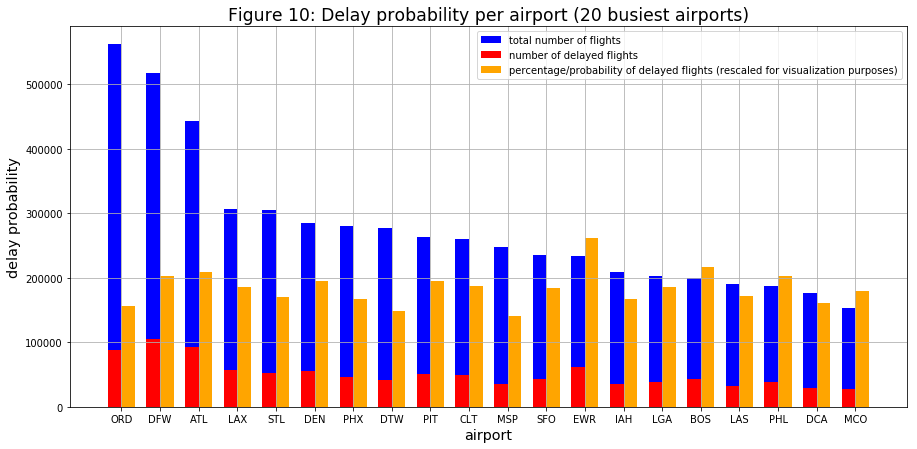

In [390]:
plot_busiest_x(df2_delay_proba_per_airport, ylabel = 'delay probability', xlabel= 'airport', title= 'Figure 10: Delay probability per airport (20 busiest airports)', range_list=range(20))

<h2> Comments </h2>
    
- The figure 10 shows that **there is no relationship between the traffic (number of flights) of an airport and the delay probability**, as we can see with **EWR** and **BOS** which have the **highest delay probability while they have a low flight volume**. On the opposite, **ORD** and **DFW** have the **highest flight volume while keeping close (or lower) delay percentage than **EWR**

### Question 4.7

What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  

In [391]:
pdf_df_busiest_carriers = pd.DataFrame(data=df_busiest_carriers.collect())
list_busiest_carriers = list(pdf_df_busiest_carriers[0][0:20])

In [392]:
df_carriers_delay = df_with_delay.filter( (df_with_delay.carrier.isin(list_busiest_carriers)) & (df_with_delay.is_delay==1 )).groupBy(df_with_delay.carrier)\
                            .agg(func.count('*').alias('total_delay')).orderBy('total_delay', ascending=0)
df_carriers_delay = df_carriers_delay.withColumnRenamed('carrier', 'carrier_name')

#add a column with the total number of flights per carrier

df_carriers_delay = df_carriers_delay.join(df_busiest_carriers , (df_carriers_delay['carrier_name'] == df_busiest_carriers['carrier'])) 

#select the desired columns and compute the probability
df_carriers_delay_percentage = df_carriers_delay.select(df_carriers_delay.carrier, df_carriers_delay.total_delay, df_carriers_delay.total_flights)
df_carriers_delay_percentage = df_carriers_delay_percentage.withColumn('delay_percentage', round( (100*df_carriers_delay_percentage.total_delay/df_carriers_delay_percentage.total_flights), 2))

df_carriers_delay_percentage = df_carriers_delay_percentage.orderBy('total_flights', ascending=0)
df_carriers_delay_percentage.show()

+-------+-----------+-------------+----------------+
|carrier|total_delay|total_flights|delay_percentage|
+-------+-----------+-------------+----------------+
|     DL|     160287|       874526|           18.33|
|     US|     158046|       857906|           18.42|
|     AA|     126575|       722277|           17.52|
|     UA|     107727|       638750|           16.87|
|     WN|      72543|       565426|           12.83|
|     CO|      94813|       484834|           19.56|
|     NW|      62513|       482798|           12.95|
|     TW|      47025|       258205|           18.21|
|     HP|      33125|       177851|           18.63|
|     AS|      18754|       117475|           15.96|
+-------+-----------+-------------+----------------+



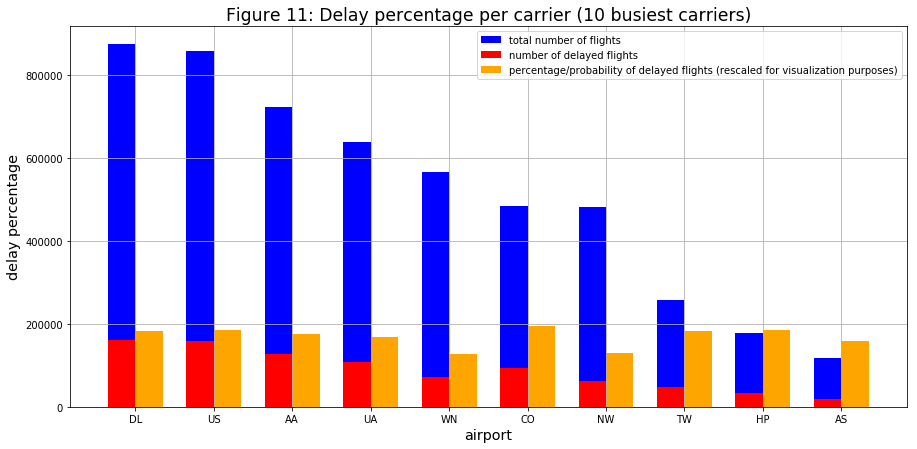

In [393]:
df2_delay_proba_per_carrier = df_carriers_delay_percentage[['carrier', 'total_delay', 'total_flights', 'delay_percentage']].toPandas()
plot_busiest_x(df2_delay_proba_per_carrier, ylabel = 'delay percentage', xlabel= 'airport', title= 'Figure 11: Delay percentage per carrier (10 busiest carriers)', range_list=range(10))

<h2> Comments </h2>
    
- As seen with airports in Figure 10, the figure 11 shows that **there is no relationship between the traffic of a carrier and its delay probability**